# LITHO1.0

Description of the model
- The LITHO1.0 model is a 1° tessellated model of the crust and uppermost mantle of the earth, extending into the upper mantle to include the lithospheric lid and underlying asthenosphere. The model is parameterized laterally by tessellated nodes and vertically as a series of geophysically identified layers, such as water, ice, sediments, crystalline crust, lithospheric lid, and asthenosphere. LITHO1.0 was created by constructing an appropriate starting model, including CRUST1.0 as starting model for the crust. We then perturbed the model to fit high-resolution surface wave dispersion maps (Love, Rayleigh, group, phase) over a wide frequency band (5-40 mHz).
- The model was generated by examination and discussion of the model with respect to key lithospheric parameters, such as average crustal velocity, crustal thickness, upper mantle velocity, and lithospheric thickness. We then compared the constructed model with those from a number of select studies at regional and global scales and find general consistency. Details can be found in Pasyanos et al. (2014).
- It appears that LITHO1.0 represents a reasonable starting model of the earth's shallow structure (crust and uppermost mantle) for the purposes in which these models are used, such as travel time tomography or in efforts to create a 3D reference earth model. The model matches surface wave dispersion over a frequency band wider than the band used in the inversion. There are several avenues for improving the model in the future by including attenuation and anisotropy, as well as making use of surface waves at higher frequency.
- Each of the nodes has a unique profile where the layers are
  - water
  - ice
  - upper sediments
  - middle sediments
  - lower sediments
  - upper crust
  - middle crust
  - lower crust
  - lithospheric mantle (lid)
  - asthenospheric mantle
  - ak135
- Crustal parameterization was adopted from CRUST1.0 though the depth to Moho and a uniform perturbation in the crystalline crust was allowed in the inversions. Parameters of layer thickness, VP, VS, rho, and Q (placeholder values) are given explicitly for all layers. The parameters below the asthenosphere blend into the ak135 model (Kennett et al., 1995).

Reference
- Pasyanos, M.E., T.G. Masters, G. Laske, and Z. Ma (2014). LITHO1.0: An updated crust and lithospheric model of the Earth, J. Geophys. Res., 119 (3), 2153-2173, DOI: 10.1002/2013JB010626..

Pages: https://igppweb.ucsd.edu/~gabi/litho1.0.html

## Step 1: Velocity Profile Extracting
1. Extracting
2. De-duplicating

In [1]:
import numpy as np 
import os 
import matplotlib.pyplot as plt

data_folder =  "../../../OpenSWI/Datasets/Original/OpenSWI-deep/LITHO1.0/LITHO1.0/litho_model"
data_files = os.listdir(data_folder)
data_files.sort(key= lambda x:int(x.replace("node","").replace(".model","")))
len(data_files),data_files[:10]

(40962,
 ['node1.model',
  'node2.model',
  'node3.model',
  'node4.model',
  'node5.model',
  'node6.model',
  'node7.model',
  'node8.model',
  'node9.model',
  'node10.model'])

In [2]:
# node, latitude, glatitude, longitude
lon_lat_file = "../../../OpenSWI/Datasets/Original/OpenSWI-deep/LITHO1.0/LITHO1.0/Icosahedron_Level7_LatLon_mod.txt"
loc_data = np.loadtxt(lon_lat_file)
loc_data.shape

(40962, 3)

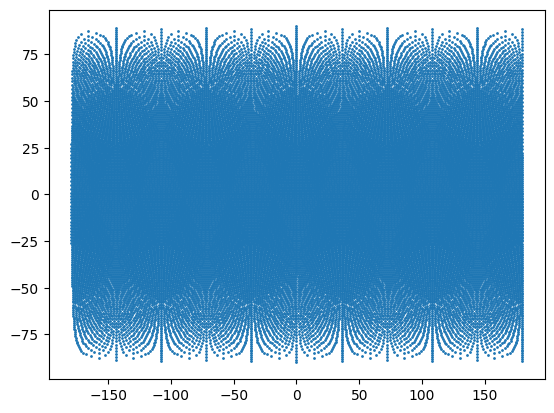

In [3]:
plt.figure()
plt.scatter(loc_data[:,2],loc_data[:,1],s=1)
plt.show()

## Step 2: Quality Control & Interpolation

1. interpolation

2. rationalizing (remove the thin layers)


In [4]:
import sys
sys.path.append('../../../')
from SWIDP.process_1d_deep import *
from SWIDP.dispersion import *

In [5]:
from scipy.interpolate import interp1d

def extract_vel(files_idx):
    depth,rho,vp,vs,layer_name = [],[],[],[],[]
    # depth(m) density(kg/m3) Vp(m/s) Vs(m/s) Qkappa Qmu Vp2(m/s) Vs2(m/s) eta layername
    lines = open(os.path.join(data_folder,data_files[files_idx]),'r').readlines()
    for i,line in enumerate(lines):
        line = line.strip().split()
        if i>0:
            depth.append(float(line[0])/1e3)
            rho.append(float(line[1])/1e3)
            vp.append(float(line[2])/1e3)
            vs.append(float(line[3])/1e3)
            layer_name.append(line[-1])
    depth = np.array(depth)[::-1]
    rho = np.array(rho)[::-1]
    vp = np.array(vp)[::-1]
    vs = np.array(vs)[::-1]
    layer_name = np.array(layer_name)[::-1]
    return depth,vp,vs,rho,layer_name

# remove interface and water layer
def remove_interface_and_water(depth,vp,vs,rho):
    # remove the interface
    depth, depth_unique_indices = np.unique(depth, return_index=True)
    vs = vs[depth_unique_indices]
    vp = vp[depth_unique_indices]
    rho = rho[depth_unique_indices]

    # remove the water layer
    water_mask    = vs>0
    depth         = depth[water_mask]
    vs            = vs[water_mask]
    vp            = vp[water_mask]
    rho           = rho[water_mask]
    
    return depth,vp,vs,rho

def interp_data(depth,vp,vs,rho,interp_method='nearest'):
    # interp
    max_depth = 300+0.1
    interp_depth = np.concatenate([
        np.arange(0, max_depth, 1)
    ])
    interp_depth_temp = interp_depth+depth.min()
    
    # interpolate velocity model
    f = interp1d(depth,vs,kind=interp_method)
    interp_vs = f(interp_depth_temp)
    f = interp1d(depth,vp,kind=interp_method)
    interp_vp = f(interp_depth_temp)
    f = interp1d(depth,rho,kind=interp_method)
    interp_rho = f(interp_depth_temp)
    
    # re
    new_depth = interp_depth
    new_vp = interp_vp
    new_vs = interp_vs
    new_rho = interp_rho
    
    return np.hstack((new_depth.reshape(-1,1),new_vp.reshape(-1,1),new_vs.reshape(-1,1),new_rho.reshape(-1,1)))

In [6]:
# -------------------------------------------------------
#  interp to 1 km thickness
# -------------------------------------------------------

vs_interp = [] 
for files_idx in range(len(data_files)):
    depth_temp,vp_temp,vs_temp,rho_temp,layer_name = extract_vel(files_idx)
    depth_temp,vp_temp,vs_temp,rho_temp = remove_interface_and_water(depth_temp,vp_temp,vs_temp,rho_temp)
    interp_vel_model = interp_data(depth_temp,vp_temp,vs_temp,rho_temp)
    vs_interp.append(interp_vel_model[:,2])
depth_interp = interp_vel_model[:,0]
vs_interp = np.array(vs_interp)
vs_interp.shape, 

((40962, 301),)

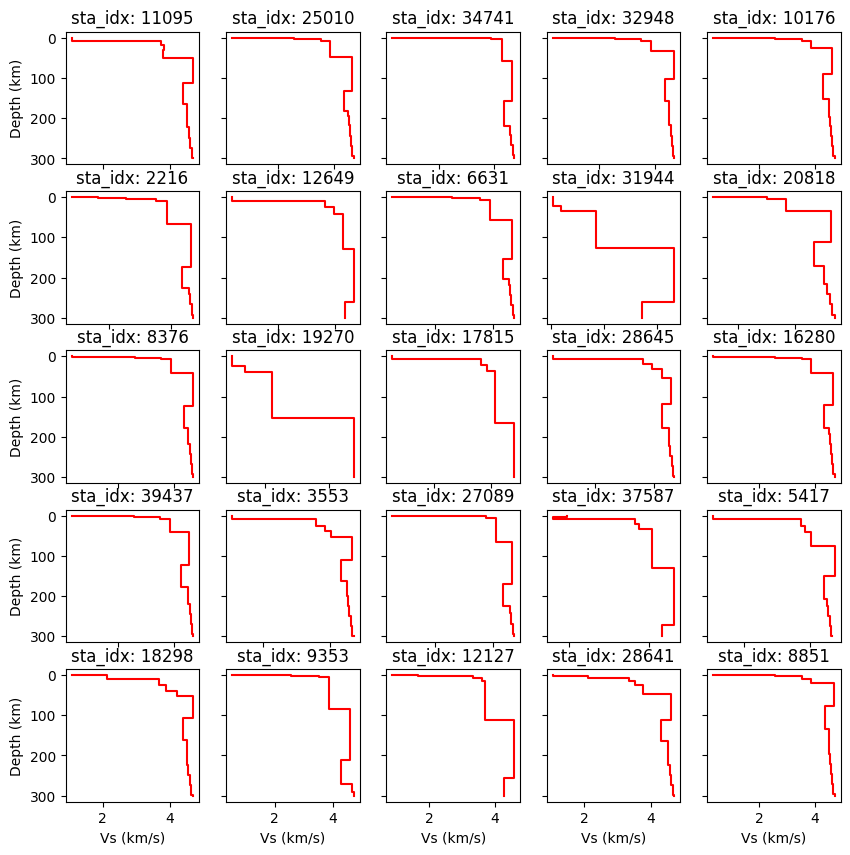

In [7]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs_interp))
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

In [8]:
# -------------------------------------------------------
#  remove the sandwich layers
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(combine_thin_sandwich,
                            vs_interp,
                            list(depth_interp.reshape(1,-1))*len(vs_interp),
                            [12]*len(vs_interp),
                            [1]*len(vs_interp),
                            [0.05]*len(vs_interp),
                            [False]*len(vs_interp))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/40962 [00:00<?, ?it/s]

(40962, 301)

In [9]:
# -------------------------------------------------------
#  Smooth velocity model (B spline/Pchip)
# -------------------------------------------------------
from p_tqdm import p_map
# process all the stations
vs_interp_rm_sandwich = p_map(smooth_vs_by_node_interp,
                            vs_interp_rm_sandwich,
                            list(depth_interp.reshape(1,-1))*len(vs_interp_rm_sandwich),
                            [12]*len(vs_interp_rm_sandwich),
                            ["pchip"]*len(vs_interp_rm_sandwich))

# find the moho depth
vs_interp_rm_sandwich = np.array(vs_interp_rm_sandwich)
vs_interp_rm_sandwich.shape


  0%|          | 0/40962 [00:00<?, ?it/s]

(40962, 301)

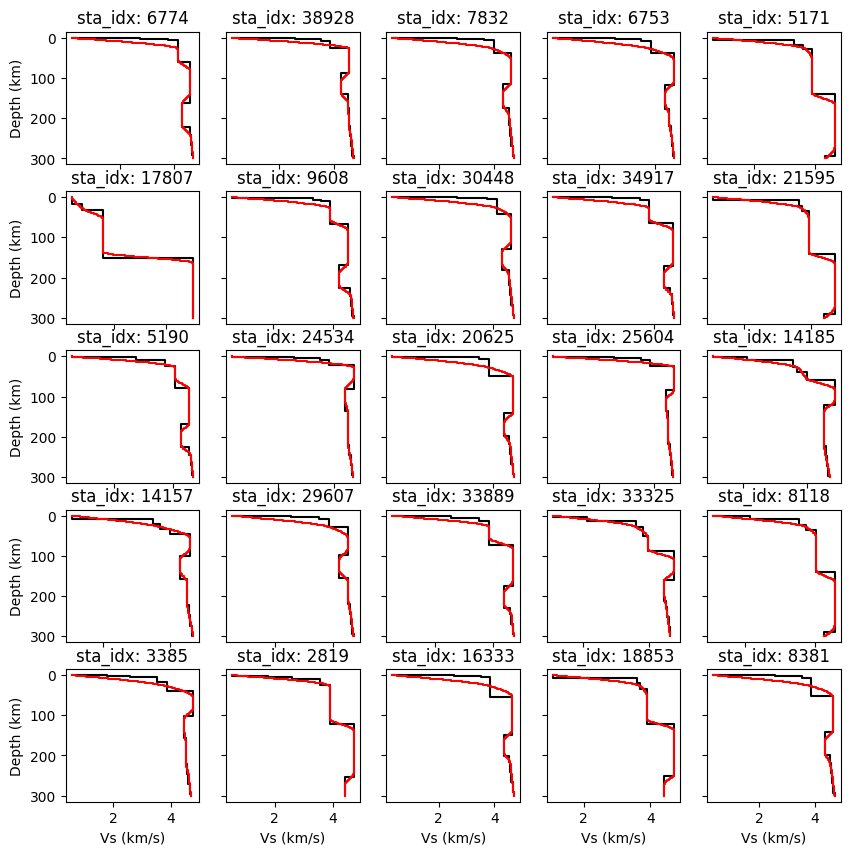

In [10]:
nrows = 5
ncols = 5
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))
for i in range(nrows):
    for j in range(ncols):
        sta_idx = np.random.randint(0,len(vs_interp))
        axs[i,j].step(vs_interp[sta_idx,:],depth_interp,c='k')
        axs[i,j].step(vs_interp_rm_sandwich[sta_idx,:],depth_interp,c='r')
        axs[i,j].invert_yaxis()
        axs[i,j].set_title(f'sta_idx: {sta_idx}')
        if j == 0:
            axs[i,j].set_ylabel('Depth (km)')
        else:
            axs[i,j].tick_params(labelleft=False)
        if i == nrows-1:
            axs[i,j].set_xlabel('Vs (km/s)')
        else:
            axs[i,j].tick_params(labelbottom=False)
plt.show()

## Step 3: Dispersion Curve Forward Modeling

In [23]:
vs_models = vs_interp_rm_sandwich.reshape(-1,vs_interp_rm_sandwich.shape[-1]) # [n_models,n_depth]
depth_models = list(depth_interp.reshape(1,-1))*len(vs_models)
vel_models = p_map(transform_vs_to_vel_model,vs_models,depth_models)
vel_models = np.array(vel_models)
vel_models.shape

  0%|          | 0/40962 [00:00<?, ?it/s]

(40962, 301, 4)

In [24]:
# Calculate dispersion curves
t = generate_mixed_samples(num_samples=300,start=1,end=100,uniform_num=100,log_num=100,random_num=100)
t = np.ones((len(vel_models),len(t)))*t
disp_data = p_map(calculate_dispersion, vel_models, list(t))
disp_data = np.array(disp_data)
vel_models = np.array(vel_models)
vel_models.shape,disp_data.shape

  0%|          | 0/40962 [00:00<?, ?it/s]

((40962, 301, 4), (40962, 300, 3))

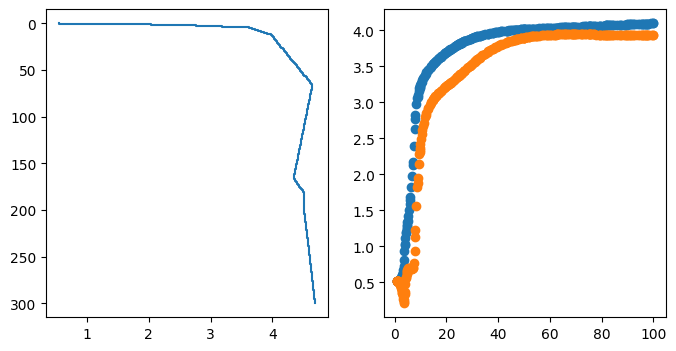

In [ ]:
nrows = 10
ncols = 10
fig,axs = plt.subplots(nrows,ncols,figsize=(10,10))

for i in range(nrows):
    for j in range(ncols//2):

        sta_idx = np.random.randint(0,vel_models.shape[0])

        # velocity profile
        axs[i,j*2].step(vel_models[sta_idx][:,2],vel_models[sta_idx][:,0],c='k')
        axs[i,j*2].set_xticks([])
        axs[i,j*2].set_yticks([])
        axs[i,j*2].invert_yaxis()

        # dispersion curve
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,1],s=2,c='r')
        axs[i,j*2+1].scatter(disp_data[sta_idx][:,0],disp_data[sta_idx][:,2],s=2,c='b')
        axs[i,j*2+1].set_xticks([])
        axs[i,j*2+1].set_yticks([])
plt.subplots_adjust(wspace=0.05,hspace=0.05)
plt.show()

In [16]:
phase_mask = np.sum(disp_data[:,:,1] == 0,axis=1)==0
group_mask = np.sum(disp_data[:,:,2] == 0,axis=1)==0
mask = phase_mask*group_mask

loc = loc_data[mask][:,[2,1]]
vel_models = vel_models[mask,:,:]
disp_data = disp_data[mask,:,:]

disp_data.shape

(40959, 300, 3)

In [ ]:
import os
save_base_path = "../../../OpenSWI/Datasets/OpenSWI-deep/1s-100s-Base"
# Save processed data as compressed npz files
np.savez_compressed(os.path.join(save_base_path, "LITHO1_loc.npz"),
                    data=loc.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "LITHO1_model.npz"),
                    data=vel_models.astype(np.float32))
np.savez_compressed(os.path.join(save_base_path, "LITHO1_disp.npz"),
                    data=disp_data.astype(np.float32))

(array([71., 34., 33., 24., 27., 22., 26., 21., 21., 21.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

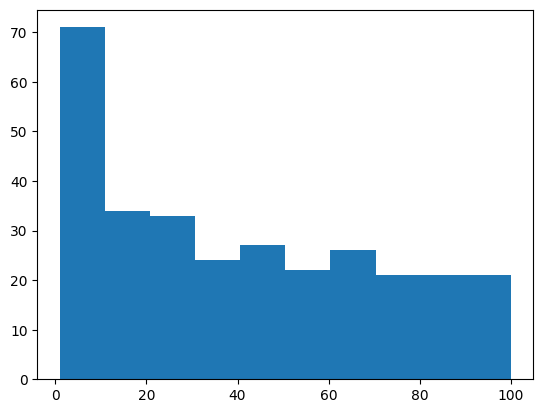

In [18]:
plt.hist(disp_data[0,:,0])

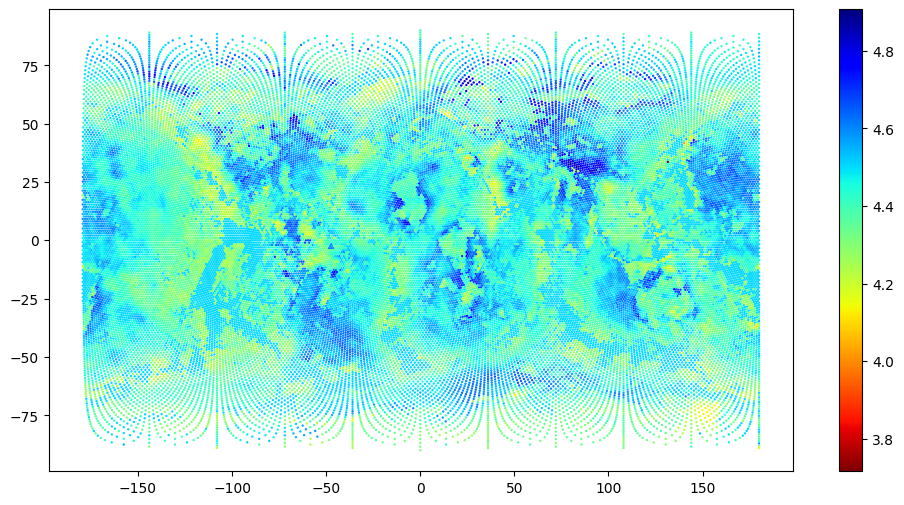

In [19]:
plt.figure(figsize=(12,6))
depth_idx = 150
plt.scatter(loc_data[:,2],loc_data[:,1],c=vs_interp[:,depth_idx],cmap='jet_r',s=0.5)
plt.colorbar()
plt.show()

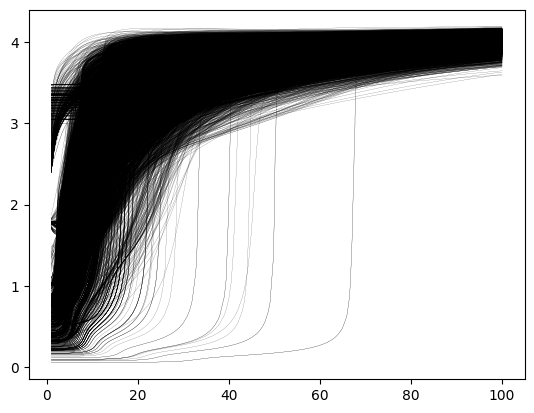

In [20]:
plt.figure()
for i in range(10000):
    plt.plot(disp_data[i,:,0],disp_data[i,:,1],c='k',linewidth=0.1)
plt.show()

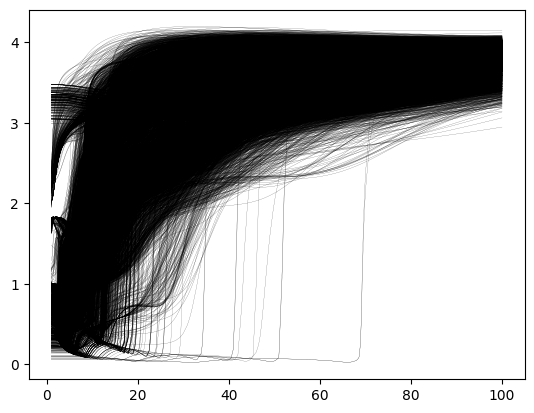

In [21]:
plt.figure()
for i in range(10000):
    plt.plot(disp_data[i,:,0],disp_data[i,:,2],c='k',linewidth=0.1)
plt.show()